In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import yaml

# from examples.constraints.context.utils import Experimenter

In [2]:
from examples.constraints.context.circle_evaluator import CircleEvaluator
from examples.constraints.context.triangle_evaluator import TriangleEvaluator
from presp.prescriptor import NNPrescriptor, NNPrescriptorFactory

class Experimenter:
    def __init__(self, results_dir: Path):
        with open(results_dir / "config.yml", "r", encoding="utf-8") as f:
            self.config = yaml.safe_load(f)

        if self.config["problem"] == "triangle":
            self.evaluator = TriangleEvaluator(**self.config["eval_params"])
        elif self.config["problem"] == "circle":
            self.evaluator = CircleEvaluator(**self.config["eval_params"])
        else:
            raise ValueError("Problem not supported")
        self.factory = NNPrescriptorFactory(NNPrescriptor, **self.config["prescriptor_params"])
        self.results_dir = results_dir

    def get_gen_df(self, gen: int, pareto: bool = True) -> pd.DataFrame:
        gen_df = pd.read_csv(self.results_dir / f"{gen}.csv")
        if pareto:
            gen_df = gen_df[gen_df["rank"] == 1]
        return gen_df

    def get_candidate_solutions(self, cand_id: str, test: bool = False) -> torch.Tensor:
        candidate = self.factory.load(self.results_dir / f"{cand_id.split('_')[0]}/{cand_id}")
        actions = self.evaluator.prescribe(candidate, test=test)
        return actions.cpu().numpy()

    def compute_hypervolume_2d(self, pareto_front: np.ndarray, ref_point: np.ndarray) -> float:
        """
        Assumes minimization.
        Pareto front is n x 2
        """
        hypervolume = 0
        pareto_front = np.sort(pareto_front, axis=0)
        for i in range(pareto_front.shape[0]):
            x1 = pareto_front[i, 0]
            x2 = pareto_front[i+1, 0] if i < pareto_front.shape[0] - 1 else ref_point[0]

            y1 = pareto_front[i, 1]
            y2 = ref_point[1]

            volume = (x2 - x1) * (y2 - y1)
            volume = max(volume, 0)
            hypervolume += volume

        return hypervolume

In [3]:
RESULTS_DIR = Path("examples/constraints/context/results/triangle-penalty")
with open(RESULTS_DIR / "config.yml", "r", encoding="utf-8") as f:
    config = yaml.safe_load(f)
# GENS = config["evolution_params"]["n_generations"]
GENS = len(list(RESULTS_DIR.glob("*.csv")))
print(GENS)

experimenter = Experimenter(RESULTS_DIR)

config

200


{'eval_params': {'device': 'mps', 'n_jobs': 1},
 'evolution_params': {'mutation_factor': 0.1,
  'mutation_rate': 0.1,
  'n_elites': 0,
  'n_generations': 200,
  'population_size': 200,
  'remove_population_pct': 0,
  'save_path': 'examples/constraints/context/results/triangle-penalty'},
 'prescriptor_params': {'device': 'mps',
  'model_params': [{'in_features': 4, 'out_features': 64, 'type': 'linear'},
   {'type': 'relu'},
   {'in_features': 64, 'out_features': 64, 'type': 'linear'},
   {'type': 'relu'},
   {'in_features': 64, 'out_features': 2, 'type': 'linear'}]},
 'problem': 'triangle'}

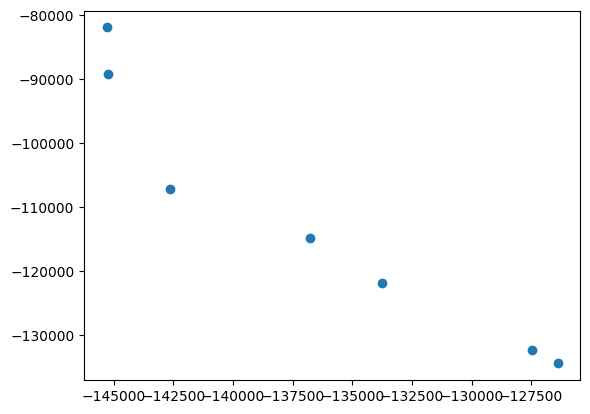

In [4]:
def plot_pareto():
    pareto_df = experimenter.get_gen_df(GENS)
    fig, ax = plt.subplots()
    ax.scatter(pareto_df["f1"], pareto_df["f2"])
    plt.show()

plot_pareto()

In [5]:
def plot_solution_space(ax: plt.Axes, context_idx: int, gen: int, color_idx: int, plot_optimal: bool = True, test: bool = False):

    pareto_df = experimenter.get_gen_df(gen, pareto=True)

    all_X = []
    for cand_id in pareto_df["cand_id"]:
        X = experimenter.get_candidate_solutions(cand_id, test)
        all_X.append(X[context_idx])
    all_X = np.stack(all_X)
    x1s = all_X[:, 0]
    x2s = all_X[:, 1]

    label = context_idx
    if test:
        label = f"test_{context_idx}"
    ax.scatter(x1s, x2s, label=label, color=f"C{color_idx}")

    if plot_optimal:
        optimal = experimenter.evaluator.get_optimal_actions(test=test).cpu().numpy()
        optimal_c = optimal[context_idx]
        ax.plot(optimal_c[0], optimal_c[1], color=f"C{color_idx}", linestyle="--")
    return ax

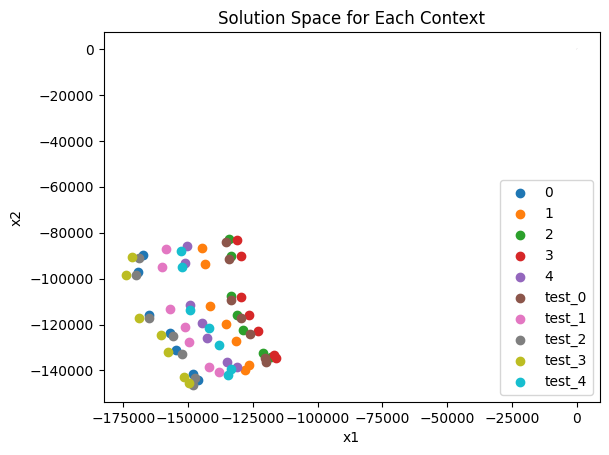

In [6]:
fig, ax = plt.subplots()
for context_idx in range(5):
    ax = plot_solution_space(ax, context_idx, GENS, context_idx, plot_optimal=True)

for context_idx in range(5):
    ax = plot_solution_space(ax, context_idx, GENS, context_idx + 5, plot_optimal=True, test=True)

ax.legend()
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_title("Solution Space for Each Context")

plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'examples/constraints/context/results/triangle-penalty/1000.csv'

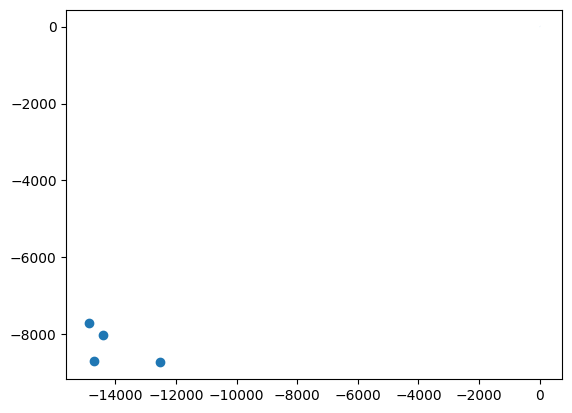

Bad pipe message: %s [b'`\xc4\x0cty\x06\xe5\xd9rhK}yJU\xb9\xcd\xc1\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x006\x007\x008\x009\x00:\x00;\x00<\x00=\x00>\x00?\x00@\x00A\x00B\x00C\x00D\x00E\x00F\x00g\x00h\x00i\x00j\x00k\x00l\x00m\x00\x84\x00\x85\x00\x86\x00\x87\x00\x88\x00\x89\x00\x96\x00\x97\x00\x98\x00\x99\x00\x9a\x00\x9b\x00\x9c\x00\x9d\x00\x9e\x00\x9f\x00\xa0\x00\xa1\x00\xa2\x00']
Bad pipe message: %s [b"\xa4\x00\xa5\x00\xa6\x00\xa7\x00\xba\x00\xbb\x00\xbc\x00\xbd\x00\xbe\x00\xbf\x00\xc0\x00\xc1\x00\xc2\x00\xc3\x00\xc4\x00\xc5\x13\x01\x13\x02\x13\x03\x13\x04\x13\x05\xc0\x01\xc0\x02\xc0\x03\xc0\x04\xc0\x05\xc0\x06\xc0\x07\xc0\x08\xc0\t\xc0\n\xc0\x0b\xc0\x0c\xc0\r\xc0\x0e\xc0\x0f\xc0\x10\xc0\x11\xc0\x12\xc0\x13\xc0\x14\xc0\x15\xc0\x16\xc0\x17\xc0\x18\xc0\x19\xc0#\xc0$\

In [7]:
fig, ax = plt.subplots()
for i, gen in enumerate([150, 1000]):
    ax = plot_solution_space(ax, 2, gen, i, plot_optimal=True, test=True)

ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_title("Test point r=5 over time")
ax.legend()

plt.show()